# Making Predictions with LSTM

In this notebook we will use Recurrent Neural Network (LSTM) to make the predictions on the passenger counts. 

In [34]:
#importing libaries
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from keras.callbacks import EarlyStopping
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

In [7]:
#loading the data that we processed after eda
train = pd.read_csv('data/train.csv', parse_dates=[0], index_col=[0])
train_original = pd.read_csv('data/train_original', parse_dates=['Datetime'], index_col='Datetime')
test_original = pd.read_csv('data/test_original', parse_dates=['Datetime'], index_col='Datetime')

In [8]:
train.head()

,ID,Count,year,month,day,Hour,day_of_week,weekend
Datetime,,,,,,,,
2012-08-25,11.5,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,35.5,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,59.5,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,83.5,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,107.5,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0


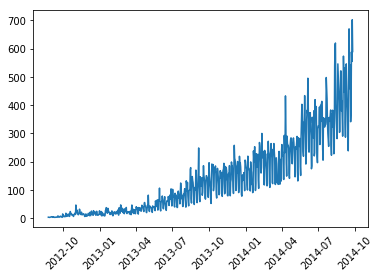

In [11]:
#visualize our time series
plt.plot(train.Count)
plt.xticks(rotation=45)
plt.show()

### Data Preprocessing

In [13]:
#reshaping the data and performing scaling
values = train.Count.values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [15]:
#splitting the data for training and validation purpose
train_size = int(len(scaled) * 0.80)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]

In [16]:
print(len(train), len(test))

609 153


In [17]:
#function for creating datasets with look back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [18]:
look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [19]:
X_train.shape, X_test.shape

((608, 1, 1), (152, 1, 1))

### Building the RNN

In [25]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(100, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = regressor.fit(X_train, Y_train, epochs = 100, batch_size = 100, validation_data=(X_test, Y_test),
                                           callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)
regressor.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 608 samples, validate on 152 samples
Epoch 1/100
608/608 [==============================] - 4s 7ms/step - loss: 0.0240 - val_loss: 0.2497
Epoch 2/100
608/608 [==============================] - 0s 143us/step - loss: 0.0198 - val_loss: 0.2295
Epoch 3/100
608/608 [==============================] - 0s 171us/step - loss: 0.0162 - val_loss: 0.2079
Epoch 4/100
608/608 [==============================] - 0s 146us/step - loss: 0.0133 - val_loss: 0.1857
Epoch 5/100
608/608 [==============================] - 0s 167us/step - loss: 0.0117 - val_loss: 0.1646
Epoch 6/100
608/608 [==============================] - 0s 159us/step - loss: 0.0115 - val_loss: 0.1471
Epoch 7/100
608/608 [==============================] - 0s 221us/step - loss: 0.0123 - val_loss: 0.1356
Epoch 8/100
608/608 [==============================] - 0s 179us/step - loss: 0.0131 - val_loss: 0.1297
Epoch 9/100
608/608 [================

Lets plot the graph to see amount of loss according to the epoch

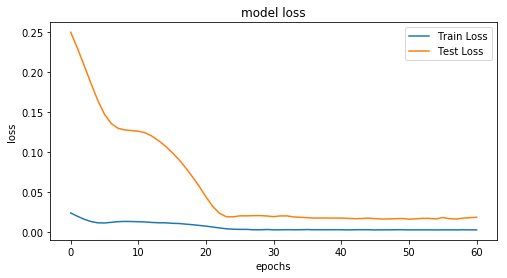

In [26]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

### Making Predictions

In [28]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

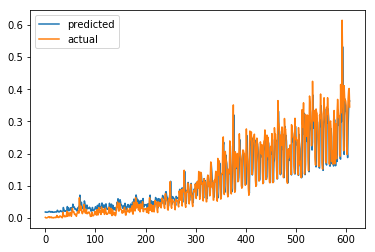

In [29]:
#plot training
plt.plot(train_predict, label='predicted')
plt.plot(Y_train, label='actual')
plt.legend(loc = 'best')
plt.show()

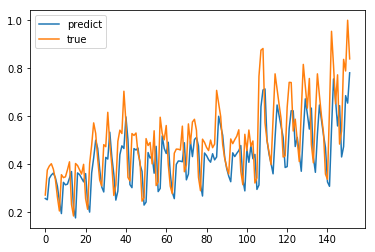

In [30]:
#plot testing
pyplot.plot(test_predict, label='predict')
pyplot.plot(Y_test, label='true')
pyplot.legend()
pyplot.show()

In [31]:
#invert predictions back to normal values
test_predict_inverse = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
train_predict_inverse = scaler.inverse_transform(train_predict.reshape(-1,1))
Y_train_inverse = scaler.inverse_transform(Y_train.reshape(-1,1))

In [39]:
from utility import evaluate_model
print("Training Errors:")
evaluate_model(Y_train_inverse,train_predict_inverse)

Training Errors:
Evaluation Metrics:
--------------------
RMS:35.51760482788086
MAPE:0.35375264286994934
MPE:-0.10741650313138962
--------------------


In [40]:
print("Testing Errors:")
evaluate_model(Y_test_inverse, test_predict_inverse)

Testing Errors:
Evaluation Metrics:
--------------------
RMS:95.53313446044922
MAPE:0.2558559477329254
MPE:0.17634516954421997
--------------------
